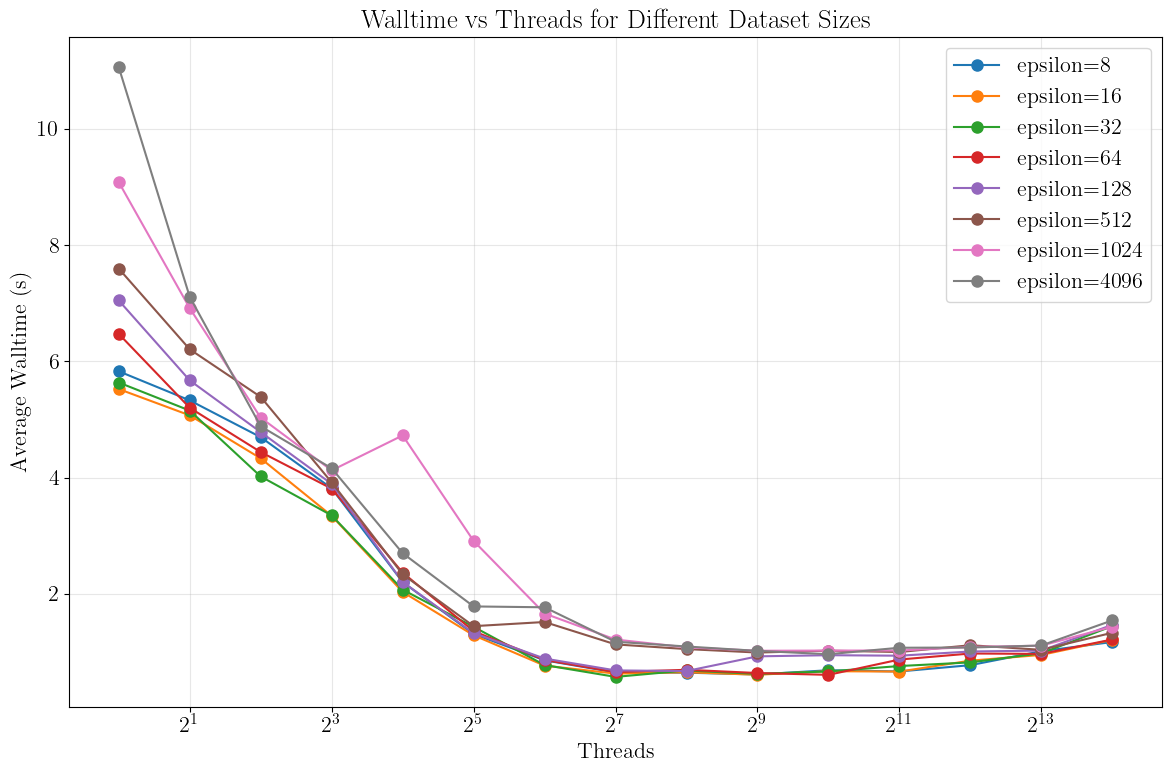

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    df = pd.read_csv(file_path)
    return df['threads'], df['avg_walltime_s']

# 文件名模式
file_patterns = ['8_falcon_multithread.csv', '16_falcon_multithread.csv', '32_falcon_multithread.csv',
                 '64_falcon_multithread.csv', '128_falcon_multithread.csv', '512_falcon_multithread.csv',
                 '1024_falcon_multithread.csv', '4096_falcon_multithread.csv']

# 创建图表
plt.figure(figsize=(12, 8))

# 为每个文件绘制一条线
for file_pattern in file_patterns:
    try:
        # 提取文件前缀作为标签
        label = file_pattern.split('_')[0]
        threads, avg_walltime_s = load_data(file_pattern)
        plt.plot(threads, avg_walltime_s, marker='o', label=f'epsilon={label}')
    except FileNotFoundError:
        print(f"文件 {file_pattern} 未找到，跳过")
        continue

# 设置图表属性
plt.xlabel('Threads')
plt.ylabel('Average Walltime (s)')
plt.title('Walltime vs Threads for Different Dataset Sizes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)  # 使用对数刻度，基数为2
# plt.yscale('log', base=10)  # 使用对数刻度

# 显示图表
plt.tight_layout()
plt.show()

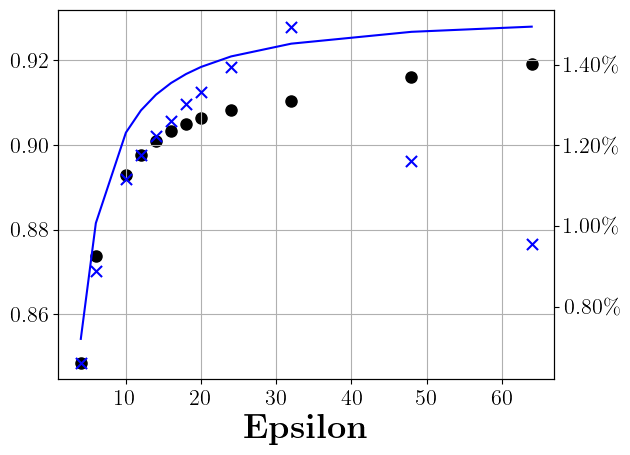

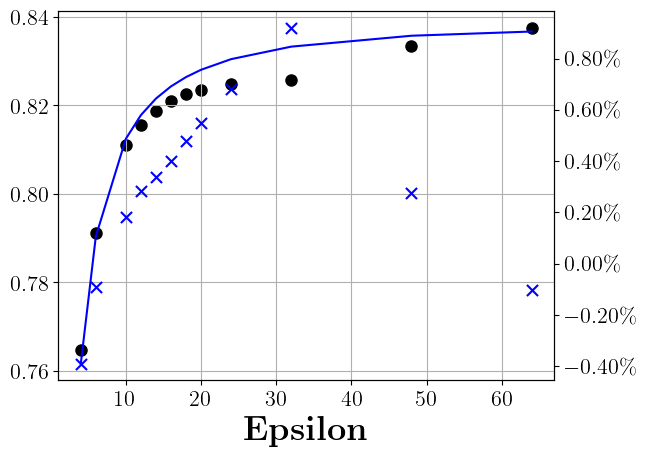

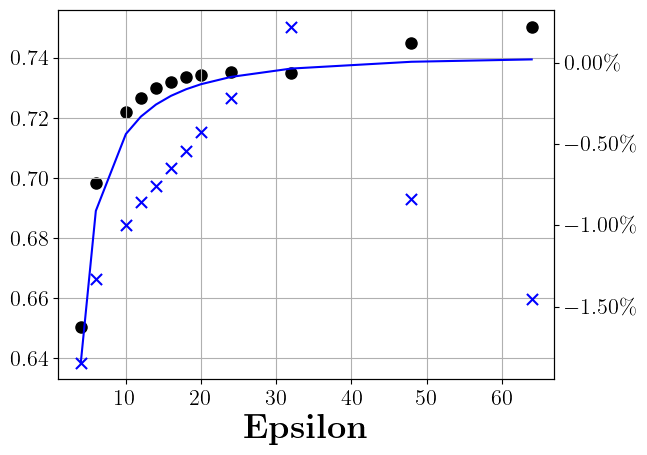

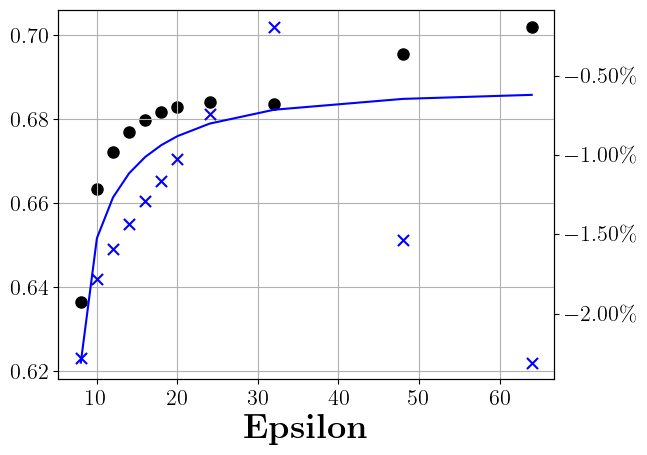

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

LOG_PATH = "/mnt/home/zwshi/learned-index/cost-model/visualize/data/log/"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def load_data(file_path,max_eps=64):
    df = pd.read_csv(file_path)
    grouped = df.groupby('epsilon', as_index=False)['hit_ratio'].mean()
    grouped = grouped.rename(columns={'hit_ratio': 'real'})
    grouped = grouped[grouped["epsilon"]<=max_eps] 
    return grouped

def load_log(log_file_path, M=20, query_nums=1e6, max_eps=64):
    df = pd.read_csv(log_file_path)
    df = df[df['M'] == M]
    grouped = df.groupby('epsilon', as_index=False)['ratio'].mean()
    grouped['expected'] = grouped['ratio']
    grouped = grouped[grouped["epsilon"] <= max_eps]
    return grouped[['epsilon', 'expected']] 

def prepare_merged(file_path, log_file_path, M=20, query_nums=1e6):
    real_df = load_data(file_path)
    # print(real_df)
    exp_df  = load_log(log_file_path, M, query_nums)
    # print(exp_df)
    merged = pd.merge(real_df, exp_df, on='epsilon', how='inner').sort_values('epsilon')
    merged['rel_err'] = (merged['expected'] - merged['real']) / merged['real']
    return merged

# === 新增：预计算全局 y 轴范围（左轴：IO；右轴：相对误差%）===
def compute_global_limits(tasks, log_file_path, query_nums=1e6, max_eps=64, pad_ratio=0.05):
    """
    tasks: [(csv_path, M), (csv_path, M), ...]
    返回： (y_io_min, y_io_max), (y_err_min_pct, y_err_max_pct)
    """
    io_min, io_max = float('inf'), float('-inf')
    err_min, err_max = float('inf'), float('-inf')
    for csv_path, M in tasks:
        merged = prepare_merged(csv_path, log_file_path, M, query_nums)
        if len(merged)==0: 
            continue
        # 左轴：真实/预测 hit_ratio
        cur_min = min(merged['real'].min(), merged['expected'].min())
        cur_max = max(merged['real'].max(), merged['expected'].max())
        io_min = min(io_min, cur_min)
        io_max = max(io_max, cur_max)
        # 右轴：相对误差（转百分比）
        cur_e_min = (merged['rel_err']*100).min()
        cur_e_max = (merged['rel_err']*100).max()
        err_min = min(err_min, cur_e_min)
        err_max = max(err_max, cur_e_max)
    # 加一点边距，避免顶边
    io_pad  = (io_max-io_min)*pad_ratio if np.isfinite(io_min) and np.isfinite(io_max) else 0
    err_pad = (err_max-err_min)*pad_ratio if np.isfinite(err_min) and np.isfinite(err_max) else 0
    return (io_min-io_pad, io_max+io_pad), (err_min-err_pad, err_max+err_pad)

def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    # revi = prepare_merged(file_path, revision_log_path, M, query_nums)
    fig, ax = plt.subplots()
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'\textbf{\Large{Real Hit Ratio}}', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'\textbf{\Large{Expected Hit Ratio}}', color="blue")
    # ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
    #         label=r'\textbf{\Large{Revised Expected IOs}}', color="red")
    ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    # ax.set_ylabel(r'\textbf{\Huge{Total IOs}}')
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.scatter(merged['epsilon'], merged['rel_err'] * 100.0,
                label=r'\textbf{\Large{Relative Error}}', marker='x', color="blue")
    # ax2.scatter(revi['epsilon'], revi['rel_err'] * 100.0,
    #             label=r'\textbf{\Large{Revised Relative Error}}', marker='x', color="red")
    ax2.yaxis.set_major_formatter(PercentFormatter())

    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')

    plt.savefig(f"books_{M}MB_Hit_rates_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

def save_legend_figure(handles, labels, filename="Hit_rates_prediction_legend.pdf"):
    # 这里可以按需要调节 figsize 和列数 ncol
    fig_legend = plt.figure(figsize=(8, 1.8))
    # frameon=False 去掉边框，方便丢到 Overleaf 里排版
    fig_legend.legend(handles, labels, loc='center', ncol=5, frameon=False)
    fig_legend.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig_legend)


# y_io_lim, y_err_lim_pct = compute_global_limits(tasks, LOG_PATH + 'books_10M_uint64_unique.query.log')

handles, labels = plot_data('books_10M_M60_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 60)

plot_data('books_10M_M40_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 40)

plot_data('books_10M_M20_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 20)

plot_data('books_10M_M10_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 10)

save_legend_figure(handles, labels)




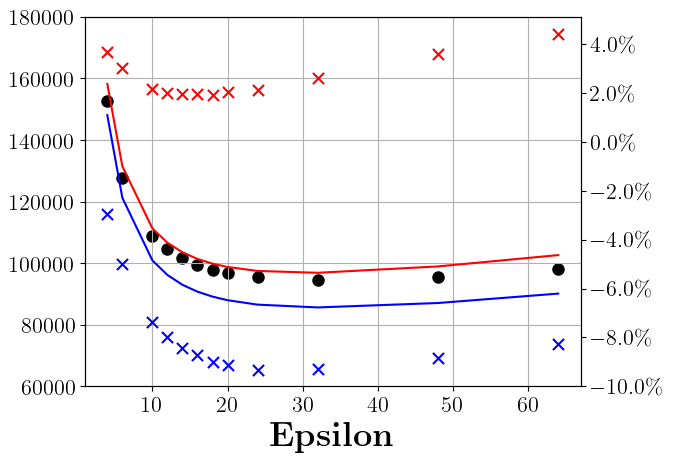

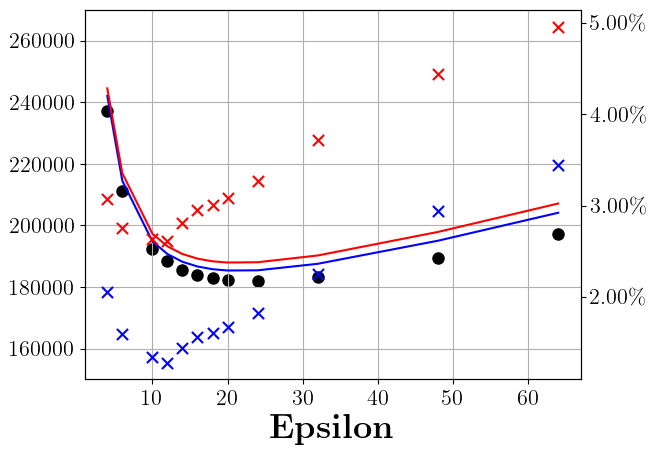

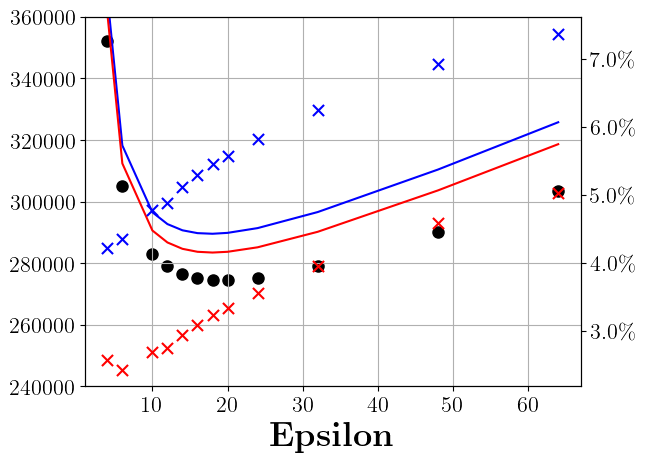

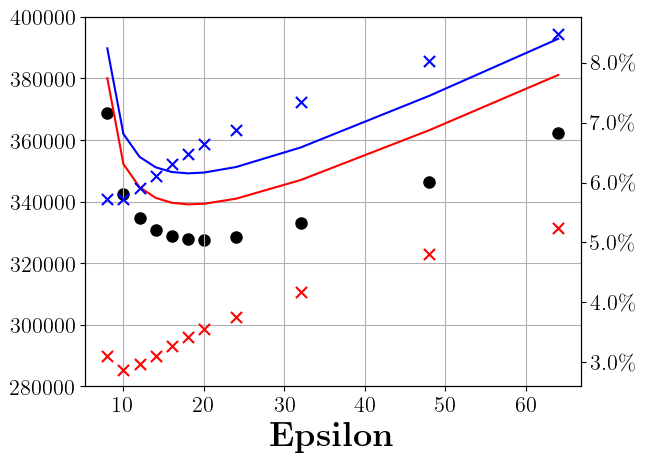

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

LOG_PATH = "/mnt/home/zwshi/learned-index/cost-model/visualize/data/log/"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def load_data(file_path,max_eps=64):
    df = pd.read_csv(file_path)
    grouped = df.groupby('epsilon', as_index=False)['avg_IOs'].mean()
    grouped = grouped.rename(columns={'avg_IOs': 'real'})
    grouped = grouped[grouped["epsilon"]<=max_eps] 
    return grouped

def load_log(log_file_path, M=20, query_nums=1e6, max_eps=64):
    df = pd.read_csv(log_file_path)
    df = df[df['M'] == M]
    grouped = df.groupby('epsilon', as_index=False)['cost'].mean()
    grouped['expected'] = grouped['cost'] * query_nums
    grouped = grouped[grouped["epsilon"] <= max_eps]
    return grouped[['epsilon', 'expected']] 

def prepare_merged(file_path, log_file_path, M=20, query_nums=1e6):
    real_df = load_data(file_path)
    # print(real_df)
    exp_df  = load_log(log_file_path, M, query_nums)
    # print(exp_df)
    merged = pd.merge(real_df, exp_df, on='epsilon', how='inner').sort_values('epsilon')
    merged['rel_err'] = (merged['expected'] - merged['real']) / merged['real']
    return merged

# === 新增：预计算全局 y 轴范围（左轴：IO；右轴：相对误差%）===
def compute_global_limits(tasks, log_file_path, query_nums=1e6, max_eps=64, pad_ratio=0.05):
    """
    tasks: [(csv_path, M), (csv_path, M), ...]
    返回： (y_io_min, y_io_max), (y_err_min_pct, y_err_max_pct)
    """
    io_min, io_max = float('inf'), float('-inf')
    err_min, err_max = float('inf'), float('-inf')
    for csv_path, M in tasks:
        merged = prepare_merged(csv_path, log_file_path, M, query_nums)
        if len(merged)==0: 
            continue
        # 左轴：真实/预测 IO
        cur_min = min(merged['real'].min(), merged['expected'].min())
        cur_max = max(merged['real'].max(), merged['expected'].max())
        io_min = min(io_min, cur_min)
        io_max = max(io_max, cur_max)
        # 右轴：相对误差（转百分比）
        cur_e_min = (merged['rel_err']*100).min()
        cur_e_max = (merged['rel_err']*100).max()
        err_min = min(err_min, cur_e_min)
        err_max = max(err_max, cur_e_max)
    # 加一点边距，避免顶边
    io_pad  = (io_max-io_min)*pad_ratio if np.isfinite(io_min) and np.isfinite(io_max) else 0
    err_pad = (err_max-err_min)*pad_ratio if np.isfinite(err_min) and np.isfinite(err_max) else 0
    return (io_min-io_pad, io_max+io_pad), (err_min-err_pad, err_max+err_pad)

def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    revi = prepare_merged(file_path, revision_log_path, M, query_nums)
    fig, ax = plt.subplots()
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'\textbf{\Large{Real IOs}}', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'\textbf{\Large{Expected IOs}}', color="blue")
    ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
            label=r'\textbf{\Large{Revised Expected IOs}}', color="red")
    ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    # ax.set_ylabel(r'\textbf{\Huge{Total IOs}}')
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.scatter(merged['epsilon'], merged['rel_err'] * 100.0,
                label=r'\textbf{\Large{Relative Error}}', marker='x', color="blue")
    ax2.scatter(revi['epsilon'], revi['rel_err'] * 100.0,
                label=r'\textbf{\Large{Revised Relative Error}}', marker='x', color="red")
    ax2.yaxis.set_major_formatter(PercentFormatter())

    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')

    plt.savefig(f"books_{M}MB_IOs_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

def save_legend_figure(handles, labels, filename="IOs_prediction_legend.pdf"):
    # 这里可以按需要调节 figsize 和列数 ncol
    fig_legend = plt.figure(figsize=(8, 1.8))
    # frameon=False 去掉边框，方便丢到 Overleaf 里排版
    fig_legend.legend(handles, labels, loc='center', ncol=5, frameon=False)
    fig_legend.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig_legend)

# ===== 用法：先算全局范围，再按同一范围出图 =====
tasks = [
    ('books_10M_M40_falcon.csv', 40),
    ('books_10M_M20_falcon.csv', 20),
    ('books_10M_M10_falcon.csv', 10),
]
# y_io_lim, y_err_lim_pct = compute_global_limits(tasks, LOG_PATH + 'books_10M_uint64_unique.query.log')

handles, labels = plot_data('books_10M_M60_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 60, y_io_lim=(60000,180000))

plot_data('books_10M_M40_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 40, y_io_lim=(150000,270000))

plot_data('books_10M_M20_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 20, y_io_lim=(240000,360000))

plot_data('books_10M_M10_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 10, y_io_lim=(280000,400000))

save_legend_figure(handles, labels)




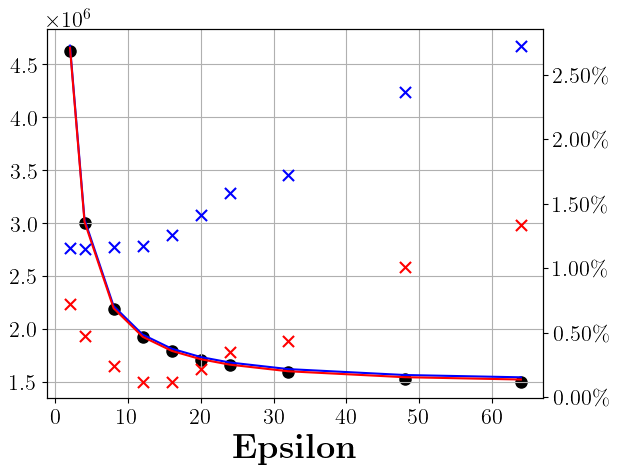

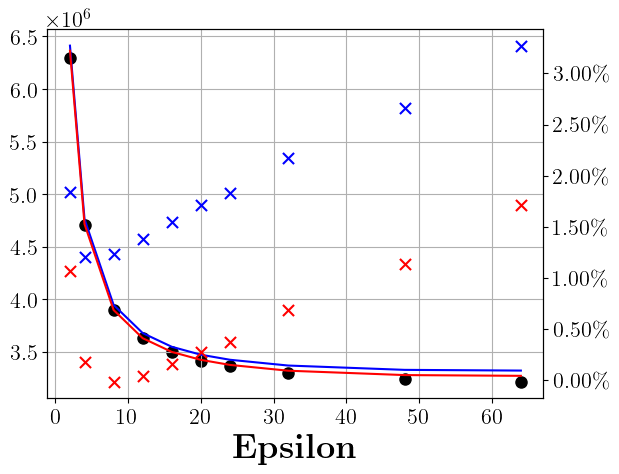

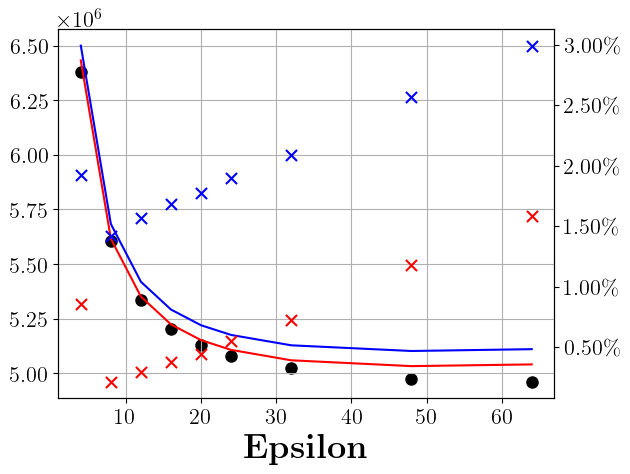

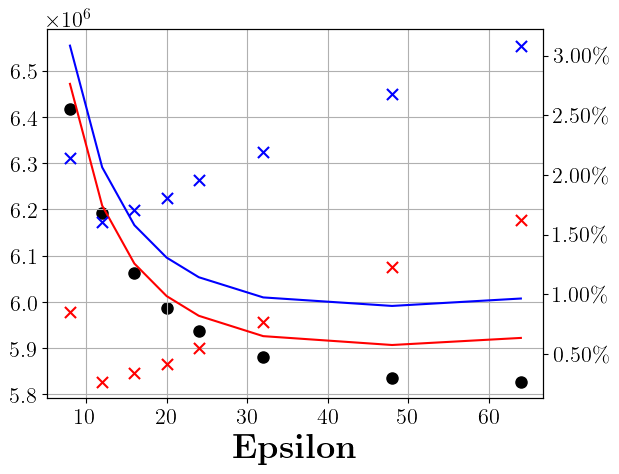

In [20]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

plot_data('range_fb_10M_M60.csv', LOG_PATH + 'range_query_1M_uu.log',
          LOG_PATH + 'range_query_1M_uu_revision.log',60)
plt.show()
plot_data('range_fb_10M_M40.csv', LOG_PATH + 'range_query_1M_uu.log',
          LOG_PATH + 'range_query_1M_uu_revision.log',40)
plt.show()
plot_data('range_fb_10M_M20.csv', LOG_PATH + 'range_query_1M_uu.log',
          LOG_PATH + 'range_query_1M_uu_revision.log',20)
plt.show()
plot_data('range_fb_10M_M10.csv', LOG_PATH + 'range_query_1M_uu.log',
          LOG_PATH + 'range_query_1M_uu_revision.log',10)
plt.show()

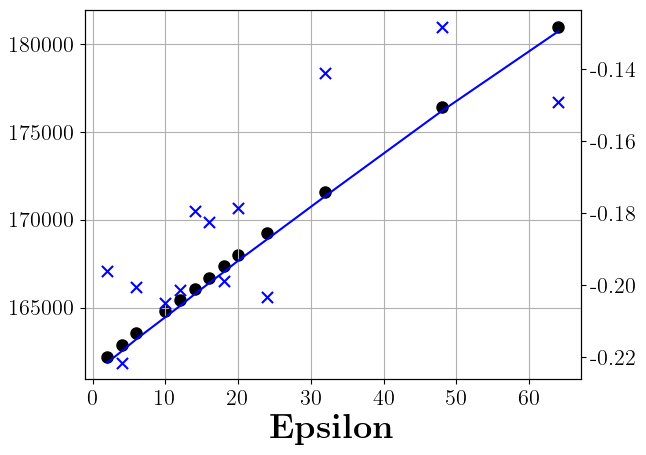

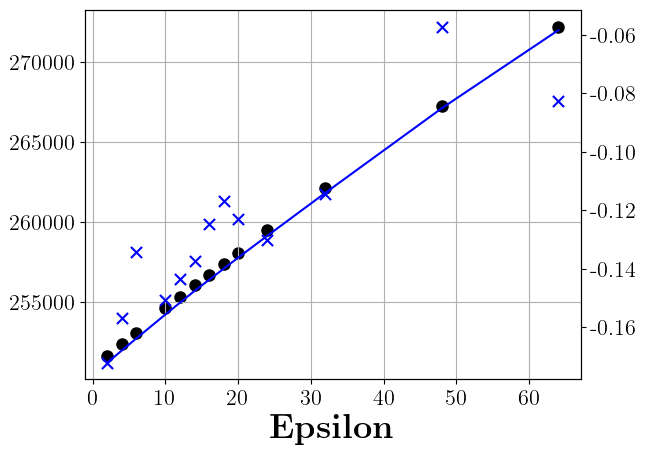

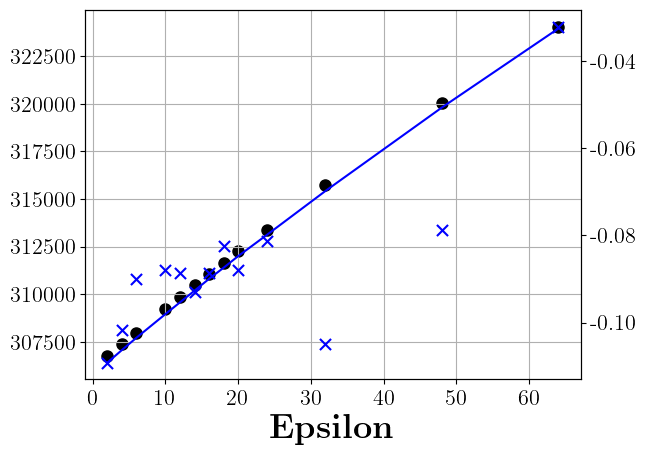

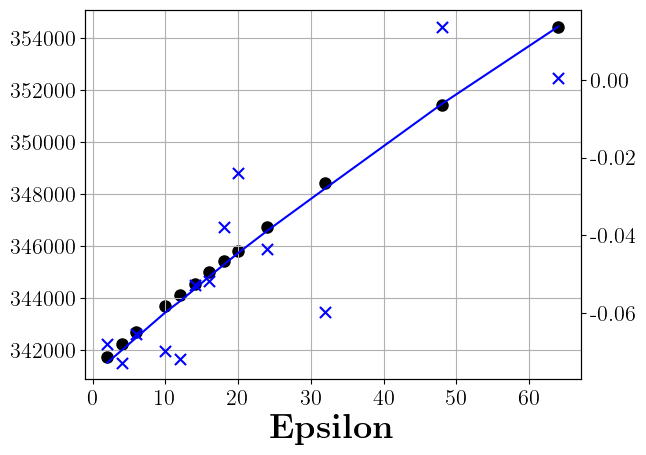

RuntimeError: latex was not able to process the following string:
b'\\\\textbf{\\\\Large{Relative Error(%)}}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp60710s_i 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
)
Runaway argument?
{\Large {Relative Error(\end {document} 
! File ended while scanning use of \textbf .
<inserted text> 
                \par 
<*> ...d1c8baecc4b93404a13a90945979e23d25f2448.tex
                                                  
No pages of output.
Transcript written on tmp60710s_i/90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a
90945979e23d25f2448.log.




Error in callback <function _draw_all_if_interactive at 0x7c5453708220> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'\\\\textbf{\\\\Large{Relative Error(%)}}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpdjkthiu1 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
)
Runaway argument?
{\Large {Relative Error(\end {document} 
! File ended while scanning use of \textbf .
<inserted text> 
                \par 
<*> ...d1c8baecc4b93404a13a90945979e23d25f2448.tex
                                                  
No pages of output.
Transcript written on tmpdjkthiu1/90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a
90945979e23d25f2448.log.




<Figure size 800x180 with 0 Axes>

In [ ]:
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mticker
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    revi = prepare_merged(file_path, revision_log_path, M, query_nums)

    fig, ax = plt.subplots()
    ax.ticklabel_format(axis='y', style='plain', useOffset=False)
    
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'\textbf{\Large{Real IOs}}', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'\textbf{\Large{Expected IOs}}', color="blue")
    # ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
    #         label=r'\textbf{\Large{Revised Expected IOs}}', color="red")
    ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    # ax.set_ylabel(r'\textbf{\Huge{Total IOs}}')
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.ticklabel_format(axis='y', style='plain', useOffset=False)
    # ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=4))
    ax2.scatter(merged['epsilon'], merged['rel_err'] * 100,
                label=r'\textbf{\Large{Relative Error(%)}}', marker='x', color="blue")
    # ax2.scatter(revi['epsilon'], revi['rel_err'] * 1e6,
    #             label=r'\textbf{\Large{Revised Relative Error(ppm)}}', marker='x', color="red")
    # ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')

    plt.savefig(f"books_256MB_{int(query_nums/1e6)}Mq_IOs_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

handles,labels = plot_data('books-200M-1Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.1Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.1Mtable.join.log',256,query_nums=1e6)
plt.show()
plot_data('books-200M-2Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.2Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.2Mtable.join.log',256,query_nums=2e6)
plt.show()
plot_data('books-200M-3Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.3Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.3Mtable.join.log',256,query_nums=3e6)
plt.show()
plot_data('books-200M-4Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.4Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.4Mtable.join.log',256,query_nums=4e6)
plt.show()

# save_legend_figure(handles, labels)

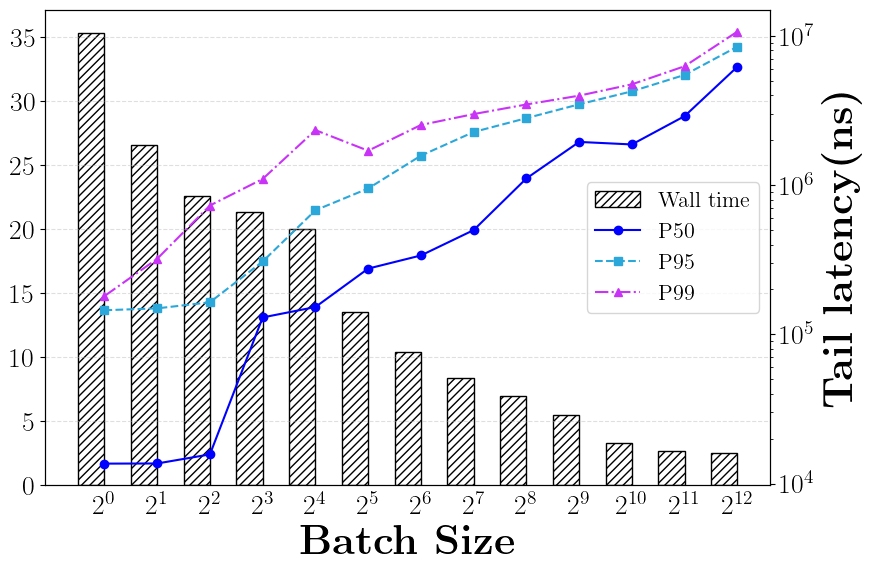

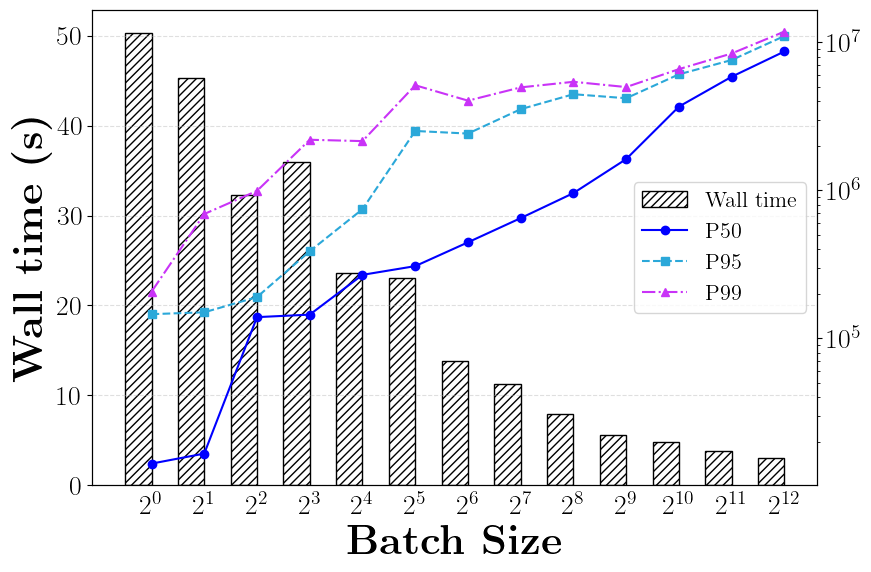

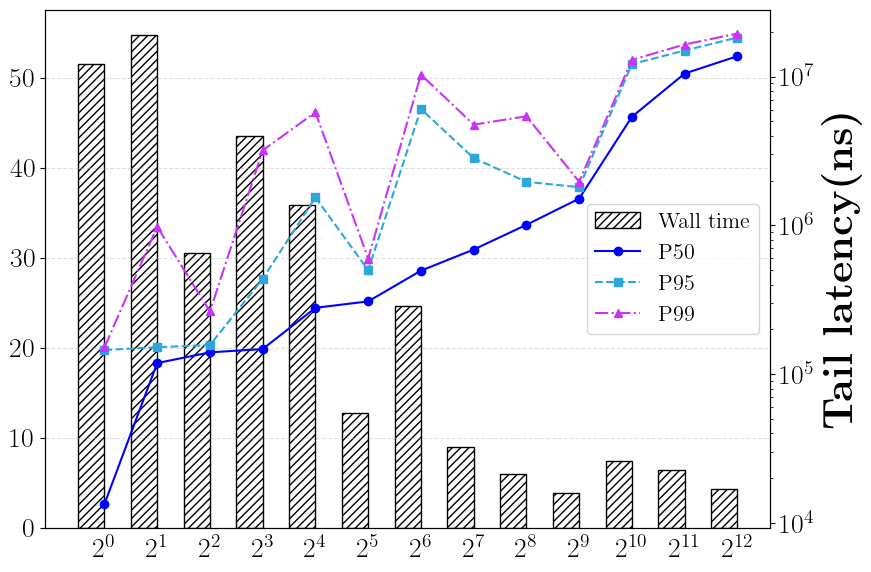

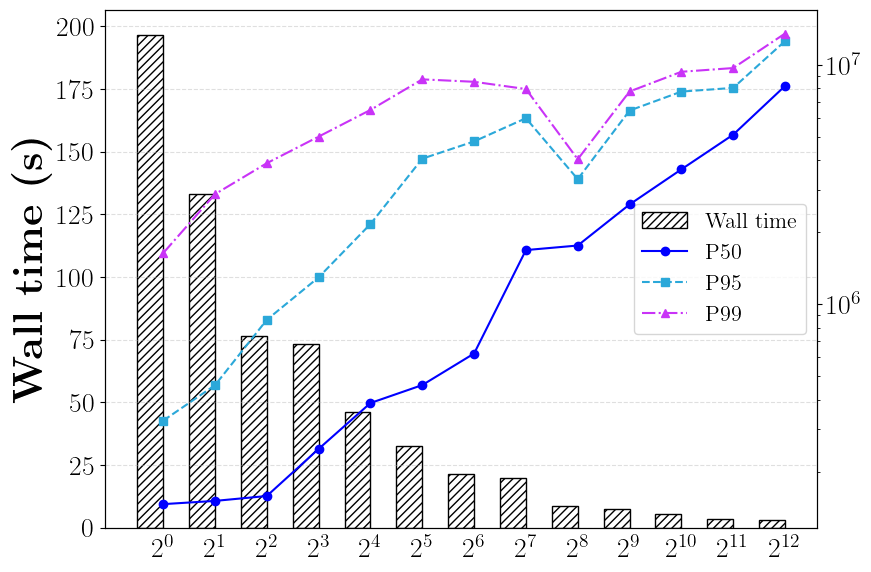

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def load_data(file_path):
    df = pd.read_csv(file_path)
    grouped = df.groupby('batch', as_index=False).agg(
        avg_walltime_s=('avg_walltime_s', 'mean'),
        p50=('p50_ns', 'mean'),
        p95=('p95_ns', 'mean'),
        p99=('p99_ns', 'mean'),
    )
    grouped = grouped.sort_values('batch')
    return grouped

def plot_one_memory(file_path, mem_MB, out_prefix):
    data = load_data(file_path)

    fig, ax_left = plt.subplots(figsize=(9.0, 6.0))
    batch = data['batch'].values.astype(float)

    x = np.log2(batch)
    width = 0.5   

    bars = ax_left.bar(
        x - width / 2.0,      # 让柱子中心对齐到真实 batch 值
        data['avg_walltime_s'],
        width=width,
        color='none',         # 颜色样式你可以按论文风格再设计
        edgecolor='black',
        hatch='////',
        label='Wall time'
    )
    if mem_MB == 20 or mem_MB == 50:
        ax_left.set_xlabel(r'\textbf{Batch Size}',fontsize=30)
    if mem_MB == 0 or mem_MB == 20: 
        ax_left.set_ylabel(r'\textbf{Wall time (s)}',fontsize=30)
    exps = np.log2(batch)
    exps_rounded = np.round(exps).astype(int)
    ax_left.set_xticks(exps_rounded)
    ax_left.set_xticklabels(
        [rf'$2^{{{e}}}$' for e in exps_rounded]
    )
    ax_left.grid(True, axis='y', linestyle='--', alpha=0.4)

    # ---------- 右轴：tail latency 折线 ----------
    ax_right = ax_left.twinx()

    # 这里假定 p50/p95/p99 的单位和 magnitude 都差不多（比如秒或毫秒），
    # 如果是 ns，记得在 load_data 里先 /1e9 或在这里除。
    line_p50, = ax_right.plot(
        x, data['p50'],
        marker='o', linestyle='-', label='P50',
        color="blue",markersize=6
    )
    line_p95, = ax_right.plot(
        x, data['p95'],
        marker='s', linestyle='--', label='P95',
        color="#2ba8d9",markersize=6
    )
    line_p99, = ax_right.plot(
        x, data['p99'],
        marker='^', linestyle='-.', label='P99',
        color="#c933f7",markersize=6
    )
    if mem_MB == 10 or mem_MB == 50: 
        ax_right.set_ylabel(r'\textbf{Tail latency(ns)}',fontsize=30)
    # 如果跨度很大，可以打开下面这行用 log 轴
    ax_right.set_yscale('log',base=10)

    # ---------- 合并图例 ----------
    # 左轴只有一个 bar handle，右轴有 3 条线，把它们合到一起
    handles_left, labels_left = ax_left.get_legend_handles_labels()
    handles_right, labels_right = ax_right.get_legend_handles_labels()
    handles = handles_left + handles_right
    labels = labels_left + labels_right

    # ax_left.legend(handles, labels, loc='center left', bbox_to_anchor=(0.58, 0.35))
    ax_left.legend(handles, labels, loc='center right')

    # ax_left.set_title(rf'\textbf{{FALCON, Memory = {mem_MB}\,MB}}')
    ax_left.tick_params(axis='both', which='both', bottom=False, top=False, labelsize=20)
    ax_right.tick_params(axis='both', which='both', bottom=False, top=False, labelsize=20)
    fig.tight_layout()
    fig.savefig(f'{out_prefix}_{mem_MB}MB.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)

def plot_all_memories(file_paths, M_list):
    """
    file_paths: 每个 memory 对应一个 csv 文件
    M_list:     对应的 memory 大小 (MB)，例如 [20,10,0]
    """
    for file_path, mem_MB in zip(file_paths, M_list):
        # 输出文件前缀自己定一个
        plot_one_memory(file_path, mem_MB, out_prefix='batch_falcon_tail')

plot_all_memories(
    ['50M_batch_falcon.csv','20M_batch_falcon.csv','10M_batch_falcon.csv','0M_batch_falcon.csv'],
    [50, 20, 10, 0]
)


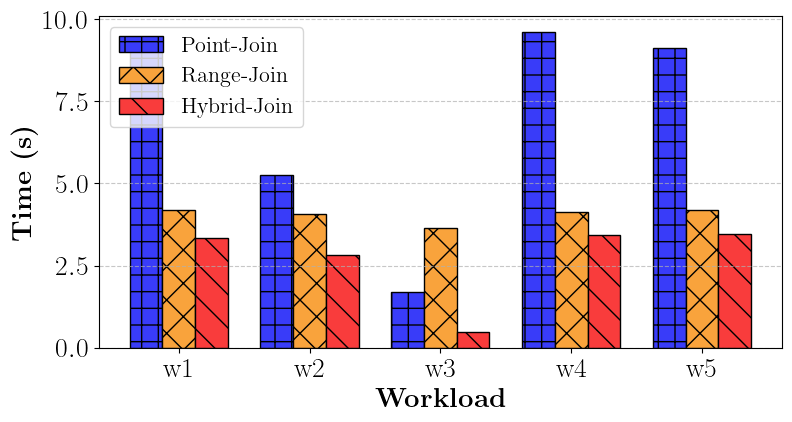

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

# ========== 配置 ==========
DATADIR = "/mnt/home/zwshi/learned-index/cost-model/include/FALCON/results/log"      
PREFIX  = "books-200M"         # 文件前缀：books-200M-point2.csv 等
CONFS   = [1, 2, 3, 4, 5]       # 你收集的 conf 编号
STRATS  = ["point", "range", "join"]  # 三种策略的顺序（也决定绘图顺序）

STYLE = [dict(facecolor="#393cf9",hatch="+"),
         dict(facecolor="#f9a33c",hatch="x"),
         dict(facecolor="#f93c3c",hatch="\\")]
# 兼容你当前三个文件里出现过的两种列名写法
WALLTIME_COL_CANDIDATES = [
    "total_wall_time_s",
]

def aggregate_walltime(series: pd.Series) -> float:
    return float(series.mean())

def find_walltime_col(df: pd.DataFrame) -> str:
    for c in WALLTIME_COL_CANDIDATES:
        if c in df.columns:
            return c
    # 更宽松兜底：匹配 total + wall + time + s
    for c in df.columns:
        if re.search(r"total.*wall.*time.*s", c, re.IGNORECASE):
            return c
    raise KeyError(f"Cannot find wall-time column in {list(df.columns)}")

def load_one(prefix: str, strat: str, n: int) -> float:
    path = os.path.join(DATADIR, f"{prefix}-{strat}{n}.csv")
    df = pd.read_csv(path)
    col = find_walltime_col(df)
    return aggregate_walltime(df[col])

# ========== 收集数据：shape = (len(CONFS), len(STRATS)) ==========
data = np.full((len(CONFS), len(STRATS)), np.nan, dtype=float)

missing = []
for i, n in enumerate(CONFS):
    for j, strat in enumerate(STRATS):
        path = os.path.join(DATADIR, f"{PREFIX}-{strat}{n}.csv")
        if not os.path.exists(path):
            missing.append(path)
            continue
        data[i, j] = load_one(PREFIX, strat, n)

if missing:
    print("Warning: missing files:")
    for p in missing:
        print("  -", p)

# ========== 画图：grouped bars ==========
x = np.arange(len(CONFS))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 4.5))

offsets = {
    "point": -width,
    "range": 0.0,
    "join":  +width,
}

for j, start in enumerate(STRATS):
    if start == "point":
        lb = "Point-Join"
    elif start == "range":
        lb = "Range-Join"
    elif start == "join":
        lb = "Hybrid-Join"
    ax.bar(x + offsets[start], data[:, j], width=width, label=lb, edgecolor='black', 
           **STYLE[j])

ax.set_xticks(x)
ax.set_xticklabels([f"w{n}" for n in CONFS])
ax.set_ylabel(r"\textbf{Time (s)}",fontsize=20)
ax.set_xlabel(r"\textbf{Workload}",fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(loc="upper left")

ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./join.pdf")
plt.show()


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16
    
def truncated_cmap(base_name="cividis", minval=0.05, maxval=0.75, n=256, reverse=False):
    base = mpl.cm.get_cmap(base_name, n)
    colors = base(np.linspace(minval, maxval, n))
    if reverse:
        colors = colors[::-1]  # 关键：反转截断后的颜色，而不是用 base_name+"_r" 再截断
    return mpl.colors.LinearSegmentedColormap.from_list(
        f"{base_name}_trunc_{minval:.2f}_{maxval:.2f}_{'r' if reverse else 'f'}",
        colors
    )
    
    
def heatmap_from_pivot(pivot: pd.DataFrame, title: str, outpath: Path, fmt=None, higher_is_better=True):
    """
    pivot: index=workers (y), columns=producers (x)
    """
    # Ensure numeric and sorted axes
    pivot = pivot.sort_index().sort_index(axis=1)

    x = pivot.columns.to_numpy()
    y = pivot.index.to_numpy()
    Z = pivot.to_numpy()

    cmap = "viridis"
    if higher_is_better:
        cmap = truncated_cmap(cmap, minval=0.05, maxval=0.75)
    else:
        cmap = truncated_cmap(cmap, minval=0.05, maxval=0.75, reverse=True)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(Z, aspect="auto", origin="lower",cmap=cmap)

    # ax.set_title(title)
    ax.set_xlabel(r"\textbf{Producers (P)}",fontsize=30)
    ax.set_ylabel(r"\textbf{Workers (W)}",fontsize=30)

    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x)
    ax.set_yticks(np.arange(len(y)))
    ax.set_yticklabels(y)

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(title, rotation=90, fontsize=30)

    # Optional: annotate each cell (useful for small grids like 5x8)
    if fmt is not None:
        for i in range(len(y)):
            for j in range(len(x)):
                val = Z[i, j]
                if np.isfinite(val):
                    ax.text(j, i, fmt.format(val), ha="center", va="center", fontsize=12, color="white")

    fig.tight_layout()
    fig.show()
    fig.savefig(outpath, dpi=200)
    plt.close(fig)

def main(csv_path: str, out_dir: str = "figs_heatmap", agg="mean"):
    csv_path = Path(csv_path)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)

    # 强制类型
    int_cols = ["producers", "workers"]
    for c in int_cols:
        df[c] = df[c].astype(int)

    # 你列名里 wall_time_ns 是 ns；有些行也可能写成 wall_time_s（若你后续改动）
    # 这里统一假设：wall_time_ns / data_IO_time_ns 都是纳秒
    # 如需兼容：可在此检查列是否存在。
    needed = ["latency_ns", "wall_time_ns", "hit_ratio", "data_IO_time_ns", "avg_IOs"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")

    # 计算一个吞吐（QPS）：Q / wall_time_s
    # 注意：如果你不同 P 线程分到的 queries 数量一致，这样可比较；否则建议用实际 queries 数。
    # 这里用“每次运行总 queries 数”估算：同一 CSV 内应相同。
    # 若你想更稳妥，把 queries 总数写进 CSV。
    # 暂时取每条记录的 avg_IOs 不用于吞吐，吞吐仅依赖 wall_time.
    # 如果你每次运行的 queries 都一样，下面 OK。
    # 假设 queries 总数 = df.groupby(['baseline']).size()?? 不对。
    # 这里让你手动填写 queries_total（最稳妥）。
    queries_total = 1000000  # e.g., 1000000
    if queries_total is not None:
        df["throughput_qps"] = queries_total / (df["wall_time_ns"] * 1e-9)
    else:
        # 退化方案：画 1 / wall_time (越大越好)，当作相对吞吐指标
        df["throughput_rel"] = 1.0 / df["wall_time_ns"]

    # 聚合 repeats：按 (P,W) 聚合
    if agg == "median":
        g = df.groupby(["workers", "producers"], as_index=False).median(numeric_only=True)
    else:
        g = df.groupby(["workers", "producers"], as_index=False).mean(numeric_only=True)

    # 1) Wall time heatmap（秒）
    wall_pivot = g.pivot(index="workers", columns="producers", values="wall_time_ns") / 1e9
    heatmap_from_pivot(
        wall_pivot,
        title=r"\textbf{Wall Time (s)}",
        outpath=out_dir / "heatmap_wall_time_s.pdf",
        fmt="{:.2f}"
    )

    # 2) Avg latency heatmap（ms）
    lat_pivot = g.pivot(index="workers", columns="producers", values="latency_ns") / 1e6
    heatmap_from_pivot(
        lat_pivot,
        title=r"\textbf{Query Latency (ms)}",
        outpath=out_dir / "heatmap_latency_ms.pdf",
        fmt="{:.2f}",
        higher_is_better=False
    )

    # 3) Hit ratio heatmap
    # hit_pivot = g.pivot(index="workers", columns="producers", values="hit_ratio")
    # heatmap_from_pivot(
    #     hit_pivot,
    #     title="Cache Hit Ratio",
    #     outpath=out_dir / "heatmap_hit_ratio.png",
    #     fmt="{:.2f}"
    # )

    # 4) Data IO time heatmap（秒）
    # io_pivot = g.pivot(index="workers", columns="producers", values="data_IO_time_ns") / 1e9
    # heatmap_from_pivot(
    #     io_pivot,
    #     title="Data I/O Time (s)",
    #     outpath=out_dir / "heatmap_data_io_time_s.png",
    #     fmt="{:.2f}"
    # )

    # 5) Throughput heatmap（相对：1/wall_time）
    if "throughput_qps" in g.columns:
        thr_pivot = g.pivot(index="workers", columns="producers", values="throughput_qps")
        heatmap_from_pivot(
            thr_pivot,
            title=r"\textbf{Throughput (QPS)}",
            outpath=out_dir / "heatmap_throughput_qps.pdf",
            fmt="{:.0f}"
        )
    else:
        thr_pivot = g.pivot(index="workers", columns="producers", values="throughput_rel")
        heatmap_from_pivot(
            thr_pivot,
            title="Relative Throughput (1 / wall_time_ns)",
            outpath=out_dir / "heatmap_throughput_rel.pdf",
            fmt="{:.2e}"
        )

    print(f"Saved heatmaps to: {out_dir.resolve()}")

main("./books_200M_uint64_unique_falcon_grid2.csv","./","mean")



/tmp/ipykernel_2327225/84035686.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)
/tmp/ipykernel_2327225/84035686.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)
/tmp/ipykernel_2327225/84035686.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)


Saved heatmaps to: /mnt/home/zwshi/learned-index/cost-model/include/FALCON/results/log
